In [1]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures
import math

In [2]:
#funcion que obtiene filas con nulls
def filasConNulls(dataset):
    is_NaN = dataset.isnull()
    row_has_NaN = is_NaN.any(axis=1)
    rows_with_NaN = dataset[row_has_NaN]
    return rows_with_NaN

In [3]:
#funcion que elimina las filas con nulls
def eliminarNulls(dataset,filas):
    dataset.drop(filas, inplace=True)
    return dataset

In [4]:
#Funcion que devuelve una lista con valores True en las posiciones que corresponde a columnas nulas
def determinar_valores_perdidos(dataset, nombreColumnas):
    resultados_por_columnas = []
    for nombre in nombreColumnas:
        res = dataset[nombre].isnull().values.any()
        resultados_por_columnas.append(res)
    return resultados_por_columnas

# Imputación de valores perdidos


Vamos a tratar los valores pérdidos mediante distintos métodos de imputación.Nos quedaremos con el que creamos más conveniente.

In [5]:
#leo dataset
dataset = pd.read_csv('all_stocks_5yr.csv', na_values= '?')
nombreColumnas = ['date', 'open', 'high', 'low', 'close','volume','Name']
#obtengo columnas con valores perdidos
res = determinar_valores_perdidos(dataset, nombreColumnas)
#obtengo filas con valores perdidos
indicesNulls=filasConNulls(dataset)
print(res)
print(indicesNulls)

[False, True, True, True, False, False, False]
              date  open   high    low     close   volume  Name
82949   2017-07-26   NaN    NaN    NaN   69.0842        3   BHF
165734  2015-07-17   NaN  88.76  88.24   88.7200  2056819   DHR
165857  2016-01-12   NaN    NaN    NaN   88.5500        0   DHR
205076  2015-07-17   NaN  48.49  47.85   47.9200  1246786    ES
239832  2016-07-01   NaN    NaN    NaN   49.5400        0   FTV
434379  2015-07-17   NaN  47.31  46.83   46.9900  1229513     O
434502  2016-01-12   NaN    NaN    NaN   52.4300        0     O
478594  2015-06-09   NaN    NaN    NaN  526.0900    12135  REGN
558213  2016-04-07   NaN    NaN    NaN   41.5600        0    UA
581906  2015-05-12   NaN    NaN    NaN  124.0800   569747  VRTX
598236  2015-06-26   NaN    NaN    NaN   61.9000      100   WRK


Como se puede apreciar en un dataframe tan grande como el que tenemos solo existen 11 filas con valores perdidos por lo que una solución muy razonable y sencilla es eliminar las filas afectadas. Aun así probaremos otros métodos.Al ver las filas afectadas se puede apreciar que en las filas afectadas falta más de un valor por lo que se pueden descartar algunos métodos como la imputación a través de la regresión. Tampoco tiene sentido hacer distintos datasets probando con cada valor de la clase ya que habría demasiadas posibilidades y muchas de ellas no tendrían sentido.
También se aprecia que las columnas con valores nulos son open,high y low.
Por último es apreciable que muchos de los valores de volume no son los adecuados en las filas con valores nulos

In [6]:
dataset[dataset['volume']<1000]

,date,open,high,low,close,volume,Name
82949,2017-07-26,NaN,NaN,NaN,69.0842,3,BHF
82951,2017-07-28,67.26,67.26,67.26,67.2600,101,BHF
165857,2016-01-12,NaN,NaN,NaN,88.5500,0,DHR
239832,2016-07-01,NaN,NaN,NaN,49.5400,0,FTV
434502,2016-01-12,NaN,NaN,NaN,52.4300,0,O
558213,2016-04-07,NaN,NaN,NaN,41.5600,0,UA
598236,2015-06-26,NaN,NaN,NaN,61.9000,100,WRK
598237,2015-06-29,60.92,60.92,60.80,60.8000,300,WRK


Como hemos dicho los valores de volume en las filas con nulos son datos no válidos ya que son muy inferiores al resto. Por lo tanto, los trataremos como valores perdidos para ello los ponemos en nulo.

In [7]:
def crearNulos(dataset,indicesNulls):
    for fila in (indicesNulls.index):
        dataset.loc[fila,'volume']=np.nan
    return dataset

In [8]:
dataset=crearNulos(dataset,indicesNulls)

ahora tratamos esos valores como null

In [9]:
#Método más sencillo eliminar las filas con valores perdidos
dataset_sin_nulls=dataset.copy()
dataset_sin_nulls=eliminarNulls(dataset_sin_nulls, indicesNulls.index)

In [10]:
#funcion sustituye nulls por media en columnas
def sustituirMedia(dataset):
    nombres_variables_numericas=dataset.select_dtypes(exclude='object').columns
    nombres_variables_categoricas=dataset.select_dtypes(include='object').columns
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    transformacion=[('transformacionnumerica', imp_mean, nombres_variables_numericas)]
    preprocesamiento=ColumnTransformer(transformers=transformacion)
    dataset_sin_missing = dataset.copy()
    dataset_sin_missing=preprocesamiento.fit_transform(dataset)
    dataset_sin_missing=pd.DataFrame(data=dataset_sin_missing,index=dataset.index,columns=np.array(nombres_variables_numericas))
    return dataset_sin_missing

In [11]:
#Sustituir por la media de la variable
aux_media=sustituirMedia(dataset[nombreColumnas[1:6]])
dataset_media=dataset.copy()
dataset_media[nombreColumnas[1:6]]=aux_media[nombreColumnas[1:6]]

Sustituir por la media de la variable no es la solución más precisa ya que incluye a muchas empresas con distintos valores.

In [12]:
#funcion sustituye nulls por media en columnas de su misma empresa
def sustituirMediaEmpresa(dataset,indicesNulls):
    dataset_media_empresa=dataset.copy()
    for fila in (indicesNulls.index):
        empresa=dataset_media_empresa.Name.iloc[fila]
        if(math.isnan(dataset_media_empresa.iloc[fila]['open'])):
            medias_open=dataset_media_empresa.groupby(['Name']).open.mean()
            media_open=medias_open.loc[empresa]
            dataset_media_empresa.at[fila,'open']=media_open
        if(math.isnan(dataset_media_empresa.iloc[fila]['high'])):
            medias_high=dataset_media_empresa.groupby(['Name']).high.mean()
            media_high=medias_high.loc[empresa]
            dataset_media_empresa.at[fila,'high']=media_high
        if(math.isnan(dataset_media_empresa.iloc[fila]['low'])):
            medias_low=dataset_media_empresa.groupby(['Name']).low.mean()
            media_low=medias_low.loc[empresa]
            dataset_media_empresa.at[fila,'low']=media_low
        if(math.isnan(dataset_media_empresa.iloc[fila]['volume'])):
            medias_volume=dataset_media_empresa.groupby(['Name']).low.mean()
            media_volume=medias_volume.loc[empresa]
            dataset_media_empresa.at[fila,'volume']=media_volume
    return dataset_media_empresa

In [13]:
#Sustituir por la media de la variable de su misma empresa
dataset_media_empresa=sustituirMediaEmpresa(dataset,indicesNulls)

Es más preciso que sustituir por la media puesto que para calcular la media sólo se tienen en cuenta los valores de la propia empresa donde imputamos

In [14]:
#funcion sustituye nulls por valor aleatorio de columnas
def sustituirValorAleatorio(dataset,indicesNulls):
    np.random.seed(123)
    dataset_valor_aleatorio=dataset.copy()
    for fila in (indicesNulls.index):
        if(math.isnan(dataset_valor_aleatorio.iloc[fila]['open'])):
            valor=np.random.randint(len(dataset))
            while(math.isnan(dataset_valor_aleatorio.iloc[valor]['open'])):
                valor=np.random.randint(len(dataset))
            dataset_valor_aleatorio.at[fila,'open']=dataset_valor_aleatorio.iloc[valor]['open']
        if(math.isnan(dataset_valor_aleatorio.iloc[fila]['high'])):
            valor=np.random.randint(len(dataset))
            while(math.isnan(dataset_valor_aleatorio.iloc[valor]['high'])):
                valor=np.random.randint(len(dataset))
            dataset_valor_aleatorio.at[fila,'high']=dataset_valor_aleatorio.iloc[valor]['high']
        if(math.isnan(dataset_valor_aleatorio.iloc[fila]['low'])):
            valor=np.random.randint(len(dataset))
            while(math.isnan(dataset_valor_aleatorio.iloc[valor]['low'])):
                valor=np.random.randint(len(dataset))
            dataset_valor_aleatorio.at[fila,'low']=dataset_valor_aleatorio.iloc[valor]['low']
        if(math.isnan(dataset_valor_aleatorio.iloc[fila]['volume'])):
            valor=np.random.randint(len(dataset))
            while(math.isnan(dataset_valor_aleatorio.iloc[valor]['volume'])):
                valor=np.random.randint(len(dataset))
            dataset_valor_aleatorio.at[fila,'volume']=dataset_valor_aleatorio.iloc[valor]['volume']
        
    return dataset_valor_aleatorio

In [15]:
#Sustituir por un valor aleatorio de la columna
dataset_valor_aleatorio=sustituirValorAleatorio(dataset,indicesNulls)

No es una función muy eficaz ya que los datos imputados en una misma fila no están relacionados y no se tiene en cuenta la empresa de pertenencia.

In [16]:
#funcion sustituye nulls por valor aleatorio de columnas con la misma empresa
def sustituirValorAleatorioEmpresa(dataset,indicesNulls):
    np.random.seed(123)
    dataset_valor_aleatorio_empresa=dataset.copy()
    for fila in (indicesNulls.index):
        empresa=dataset_valor_aleatorio_empresa.Name.iloc[fila]
        dataset_aux=dataset_valor_aleatorio_empresa.copy()
        dataset_aux=dataset_aux[dataset_aux['Name']==empresa]
        if(math.isnan(dataset_valor_aleatorio_empresa.iloc[fila]['open'])):
            valor=dataset_aux.open.iloc[np.random.randint(len(dataset_aux))]
            while(math.isnan(valor)):
                valor=dataset_aux.open.iloc[np.random.randint(len(dataset_aux))]
            dataset_valor_aleatorio_empresa.at[fila,'open']=valor
        if(math.isnan(dataset_valor_aleatorio_empresa.iloc[fila]['high'])):
            valor=dataset_aux.high.iloc[np.random.randint(len(dataset_aux))]
            while(math.isnan(valor)):
                valor=dataset_aux.high.iloc[np.random.randint(len(dataset_aux))]
            dataset_valor_aleatorio_empresa.at[fila,'high']=valor
        if(math.isnan(dataset_valor_aleatorio_empresa.iloc[fila]['low'])):
            valor=dataset_aux.low.iloc[np.random.randint(len(dataset_aux))]
            while(math.isnan(valor)):
                valor=dataset_aux.low.iloc[np.random.randint(len(dataset_aux))]
            dataset_valor_aleatorio_empresa.at[fila,'low']=valor
        if(math.isnan(dataset_valor_aleatorio_empresa.iloc[fila]['volume'])):
            valor=dataset_aux.volume.iloc[np.random.randint(len(dataset_aux))]
            while(math.isnan(valor)):
                valor=dataset_aux.volume.iloc[np.random.randint(len(dataset_aux))]
            dataset_valor_aleatorio_empresa.at[fila,'volume']=valor

        
    return dataset_valor_aleatorio_empresa

In [17]:
#Sustituir por un valor aleatorio de la columna con la misma empresa
dataset_valor_aleatorio_empresa=sustituirValorAleatorioEmpresa(dataset,indicesNulls)

Aunque se tenga en cuenta la empresa a la que pertenece el dato a imputar sigue siendo un valor aleatorio y en las filas donde se imputan varios valores, estos valores no tienen relación entre sí.

In [18]:
#funcion sustituye nulls por el valor anterior 
def sustituirValorAnterior(dataset,indicesNulls):
    dataset_valor_anterior=dataset.copy()
    for fila in (indicesNulls.index):#los indices de valores nulos van ordenados de menor a mayor
        empresa=dataset_valor_anterior.Name.iloc[fila]
        if(math.isnan(dataset_valor_anterior.iloc[fila]['open'])):
            if(dataset_valor_anterior.iloc[fila-1]['Name']==empresa):
                #al estar los índices ordenados nunca encontraremos un valor nulo por detrás
                dataset_valor_anterior.at[fila,'open']=dataset_valor_anterior.at[fila-1,'open']
            else:
                np.random.seed(123)
                dataset_aux=dataset_valor_anterior.copy()
                dataset_aux=dataset_aux[dataset_aux['Name']==empresa]
                if(math.isnan(dataset_valor_anterior.iloc[fila]['open'])):
                    valor=dataset_aux.open.iloc[np.random.randint(len(dataset_aux))]
                    while(math.isnan(valor)):
                        valor=dataset_aux.open.iloc[np.random.randint(len(dataset_aux))]
                    dataset_valor_anterior.at[fila,'open']=valor
                    
        if(math.isnan(dataset_valor_anterior.iloc[fila]['high'])):
            if(dataset_valor_anterior.iloc[fila-1]['Name']==empresa):
                #al estar los índices ordenados nunca encontraremos un valor nulo por detrás
                dataset_valor_anterior.at[fila,'high']=dataset_valor_anterior.at[fila-1,'high']
            else:
                np.random.seed(123)
                dataset_aux=dataset_valor_anterior.copy()
                dataset_aux=dataset_aux[dataset_aux['Name']==empresa]
                if(math.isnan(dataset_valor_anterior.iloc[fila]['high'])):
                    valor=dataset_aux.high.iloc[np.random.randint(len(dataset_aux))]
                    while(math.isnan(valor)):
                        valor=dataset_aux.high.iloc[np.random.randint(len(dataset_aux))]
                    dataset_valor_anterior.at[fila,'high']=valor
        
        if(math.isnan(dataset_valor_anterior.iloc[fila]['low'])):
            if(dataset_valor_anterior.iloc[fila-1]['Name']==empresa):
                #al estar los índices ordenados nunca encontraremos un valor nulo por detrás
                dataset_valor_anterior.at[fila,'low']=dataset_valor_anterior.at[fila-1,'low']
            else:
                np.random.seed(123)
                dataset_aux=dataset_valor_anterior.copy()
                dataset_aux=dataset_aux[dataset_aux['Name']==empresa]
                if(math.isnan(dataset_valor_anterior.iloc[fila]['low'])):
                    valor=dataset_aux.low.iloc[np.random.randint(len(dataset_aux))]
                    while(math.isnan(valor)):
                        valor=dataset_aux.low.iloc[np.random.randint(len(dataset_aux))]
                    dataset_valor_anterior.at[fila,'low']=valor
                    
        if(math.isnan(dataset_valor_anterior.iloc[fila]['volume'])):
            if(dataset_valor_anterior.iloc[fila-1]['Name']==empresa):
                #al estar los índices ordenados nunca encontraremos un valor nulo por detrás
                dataset_valor_anterior.at[fila,'volume']=dataset_valor_anterior.at[fila-1,'volume']
            else:
                np.random.seed(123)
                dataset_aux=dataset_valor_anterior.copy()
                dataset_aux=dataset_aux[dataset_aux['Name']==empresa]
                if(math.isnan(dataset_valor_anterior.iloc[fila]['volume'])):
                    valor=dataset_aux.volume.iloc[np.random.randint(len(dataset_aux))]
                    while(math.isnan(valor)):
                        valor=dataset_aux.volume.iloc[np.random.randint(len(dataset_aux))]
                    dataset_valor_anterior.at[fila,'volume']=valor

    return dataset_valor_anterior


In [19]:
#Sustituir por el valor anterior
dataset_valor_anterior=sustituirValorAnterior(dataset,indicesNulls)

Sustituir por el valor anterior tiene sentido ya que los datos están ordenados por fecha.Sin embargo, hay que fijarse que el dato anterior pertenezca a la misma empresa, en caso de no pertenecer, cogemos un valor entre los de la misma empresa.Creemos que se trata de la imputación con mejor resultado ya que se tiene en cuenta tanto la fecha como la empresa y habitualmente en la bolsa no hay grandes cambios de un día a otro.

Conclusión: creemos que las mejores opciones son imputar sustituyendo por el valor anterior, imputar por la media de la clase o ,la más sencilla, eliminar las filas con valores nulos.

# Comparativa de los distintos dataframes

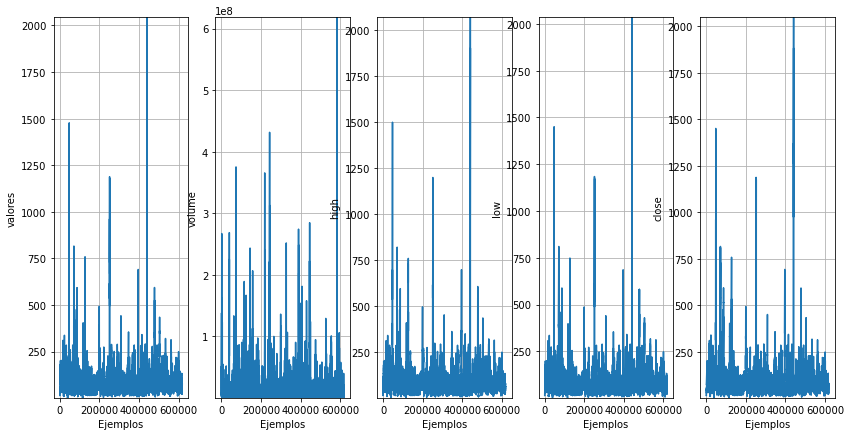

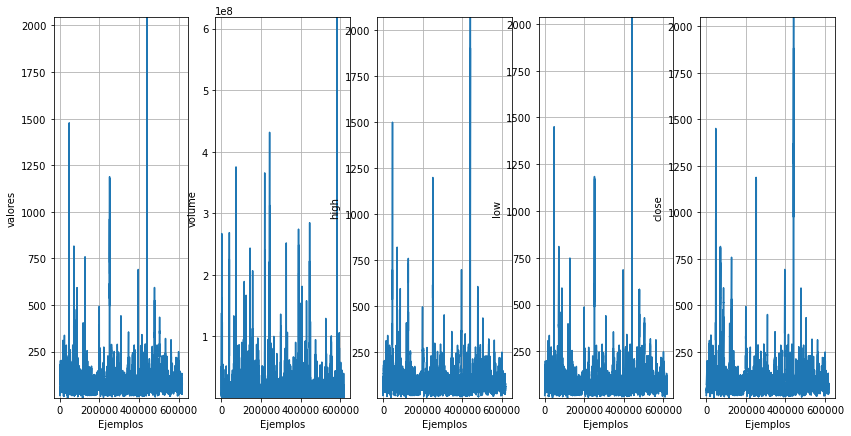

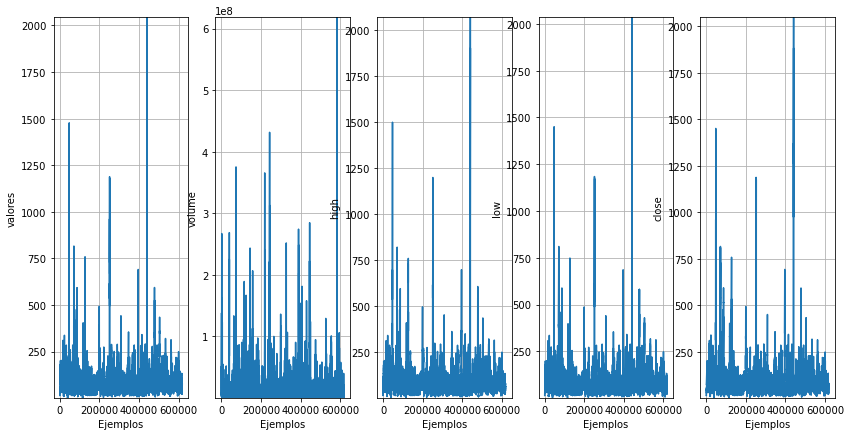

In [20]:
#vemos como están distribuidos los datos según sus valores en los datsets seleccionados
for datos in(dataset_sin_nulls,dataset_media_empresa,dataset_valor_anterior):
    resumenEntrada=datos.describe()
    plt.figure(figsize=(14,7))
    plt.subplot(151)
    plt.plot(datos['open'],label='open')
    plt.xlabel('Ejemplos')
    plt.ylabel('valores')
    plt.ylim(resumenEntrada.loc[['min','max'],'open'])
    plt.grid(True)#cuadriculado

    plt.subplot(152)
    plt.plot(datos['volume'])
    plt.xlabel('Ejemplos')
    plt.ylabel('volume')
    plt.ylim(resumenEntrada.loc[['min','max'],'volume'])
    plt.grid(True)

    plt.subplot(153)
    plt.plot(datos['high'])
    plt.xlabel('Ejemplos')
    plt.ylabel('high')
    plt.ylim(resumenEntrada.loc[['min','max'],'high'])
    plt.grid(True)

    plt.subplot(154)
    plt.plot(datos['low'])
    plt.xlabel('Ejemplos')
    plt.ylabel('low')
    plt.ylim(resumenEntrada.loc[['min','max'],'low'])
    plt.grid(True)

    plt.subplot(155)
    plt.plot(datos['close'])
    plt.xlabel('Ejemplos')
    plt.ylabel('close')
    plt.ylim(resumenEntrada.loc[['min','max'],'close'])
    plt.grid(True)


Como se podía esperar al haber tan pocos valores perdidos la distribución de los datos es prácticamente idéntica

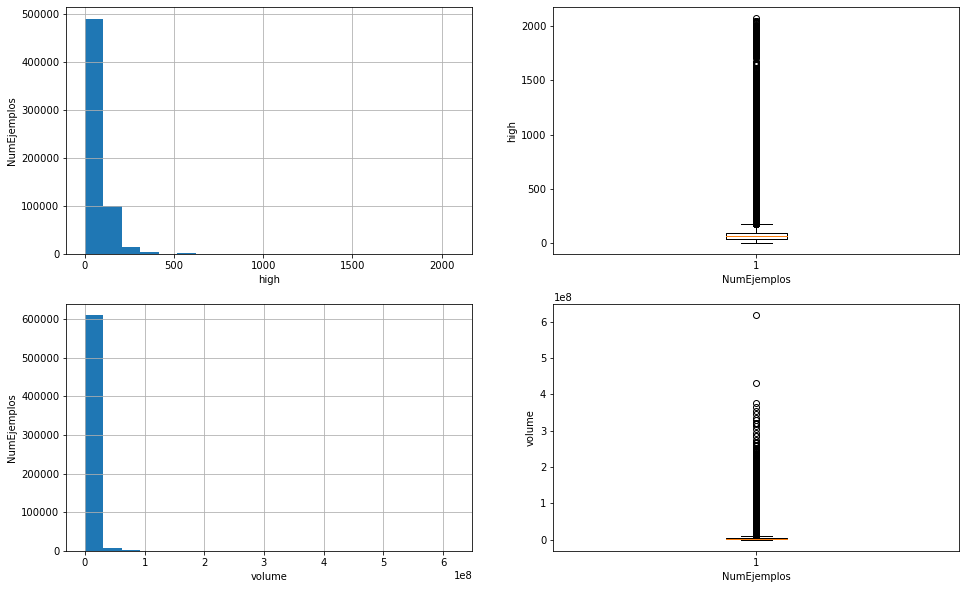

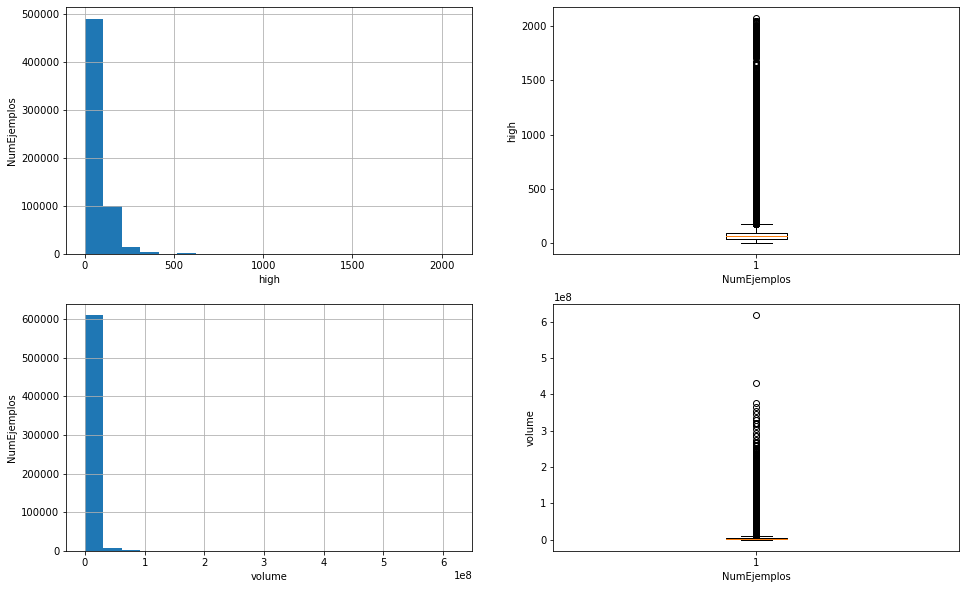

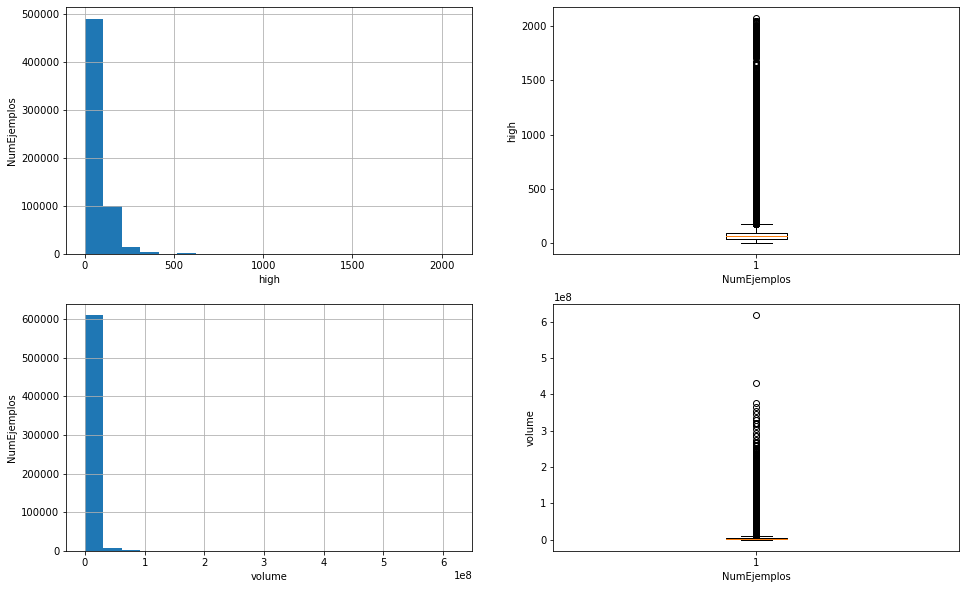

In [21]:
#veo los rangos de algunas variables
for datos in(dataset_sin_nulls,dataset_media_empresa,dataset_valor_anterior):
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,(1))
    datos['high'].hist(bins=20)
    plt.xlabel('high')
    plt.ylabel('NumEjemplos')
    plt.subplot(2,2,(2))
    plt.boxplot(datos['high'])
    plt.ylabel('high')
    plt.xlabel('NumEjemplos')
    plt.subplot(2,2,(3))
    datos['volume'].hist(bins=20)
    plt.xlabel('volume')
    plt.ylabel('NumEjemplos')
    plt.subplot(2,2,(4))
    plt.boxplot(datos['volume'])
    plt.ylabel('volume')
    plt.xlabel('NumEjemplos')

Al igual que en el apartado anterior al haber tan poca diferencia entre los dataframes, las gráficas son similares. Si que se puede apreciar que los datos se encuentran la mayoría en un rango muy similar por lo que podemos deducir que están en las mismas unidades de medida

In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import neighbors, model_selection, tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
def regresion_polinomial(dataset,dataset_output, p_degree):
    # Generamos los conjuntos de entrenamiento y de test
    X_train, X_test, y_train, y_test = train_test_split(dataset, dataset_output, test_size=0.2, random_state=12)
    # Creamos una Pipeline en la que generamos variables polinómicas de grado 2, estandarizamos los datos y aprendemos una regresión lineal
    pipePolinomial = Pipeline([('polynomial', PolynomialFeatures(degree=p_degree)),('scaler', StandardScaler()),('regressor', LinearRegression())])
    # Entrenamos la Pipeline
    pipePolinomial.fit(X_train, y_train)
    # Obtenemos el rendimiento en entrenamiento y en test (MSE)
    prTrain = pipePolinomial.predict(X_train)
    errorTrain = mean_squared_error(y_train, prTrain)
    prTest = pipePolinomial.predict(X_test)
    errorTest = mean_squared_error(y_test, prTest)
    plt.scatter(np.arange(len(y_test)),y_test,c="blue")
    plt.scatter(np.arange(len(y_test)),prTest,c="red")
    plt.xlabel("Numero de ejemplo")
    plt.xlabel("Valor de cierre")
    plt.show()
    print('El error en entrenamiento con el dataset  es {:.4f} y en test es {:.4f}'.format(errorTrain, errorTest))

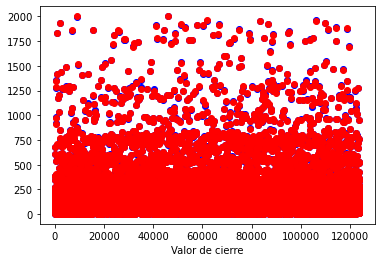

El error en entrenamiento con el dataset  es 0.4663 y en test es 0.4903


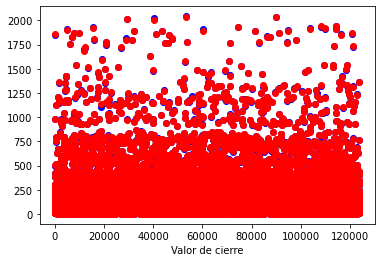

El error en entrenamiento con el dataset  es 0.5145 y en test es 0.4778


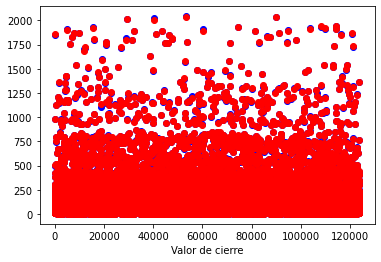

El error en entrenamiento con el dataset  es 0.4725 y en test es 0.4770


In [23]:
#utilizamos regresión polinomial para comprobar cuál de los dataframes obtiene mejores resultados mediante el error cuadrático medio
for datos in(dataset_sin_nulls,dataset_media_empresa,dataset_valor_anterior):
    atSalida = 'close'
    atEntrada = ['open','high','low','volume']
    datos_aux=datos.copy()
    dataset_output = datos_aux[atSalida].copy()
    datos_aux.drop(atSalida, axis=1, inplace=True)
    datos_aux = datos_aux[atEntrada].copy()
    X_train, X_test, y_train, y_test = train_test_split(datos_aux, dataset_output, test_size=0.2, random_state=12)
    regresion_polinomial(datos_aux,dataset_output,2,)

Como se ha podido observar el dataframe que obtiene mejores resultados es en el que se ha imputado mediante el valor anterior. Así este será el que utilicemos para la resolución del problema

# Detección de outliers

In [24]:
#detectar outliers mediante el índice IQR
def deteccionOutliers_IQR(Dataframe,k=1.5):
    IQR=Dataframe.describe().loc['75%',:]-Dataframe.describe().loc['25%',:]
    superiores=Dataframe>Dataframe.describe().loc['75%',:]+k*IQR
    inferiores=Dataframe<Dataframe.describe().loc['25%',:]-k*IQR
    resultado=np.logical_or(superiores,inferiores)
    return resultado.any(axis=1)

In [25]:
#detectar outliers mediante la media y desviación
def deteccionOutliers_MeanStd(Dataframe,k=2):
    superiores=Dataframe>Dataframe.describe().loc['mean',:]+k*Dataframe.describe().loc['std',:]
    inferiores=Dataframe<Dataframe.describe().loc['mean',:]-k*Dataframe.describe().loc['std',:]
    resultado=np.logical_or(superiores,inferiores)
    return resultado.any(axis=1)

In [26]:
#obtengo datasets sin outliers según método de IQR y método de la desviación
dataset_sin_outDesviacion=dataset_valor_anterior.copy()
outliers_ms=deteccionOutliers_MeanStd(dataset_sin_outDesviacion)
dataset_sin_outDesviacion=dataset_sin_outDesviacion[(np.logical_not(deteccionOutliers_MeanStd(dataset_sin_outDesviacion,3)))]

dataset_sin_outIQR=dataset_valor_anterior.copy()
outliers_IQR=deteccionOutliers_IQR(dataset_sin_outIQR)
dataset_sin_outIQR=dataset_sin_outIQR[(np.logical_not(deteccionOutliers_IQR(dataset_sin_outIQR,3)))]


Ahora comprobaremos los resultados de la eliminación de outliers

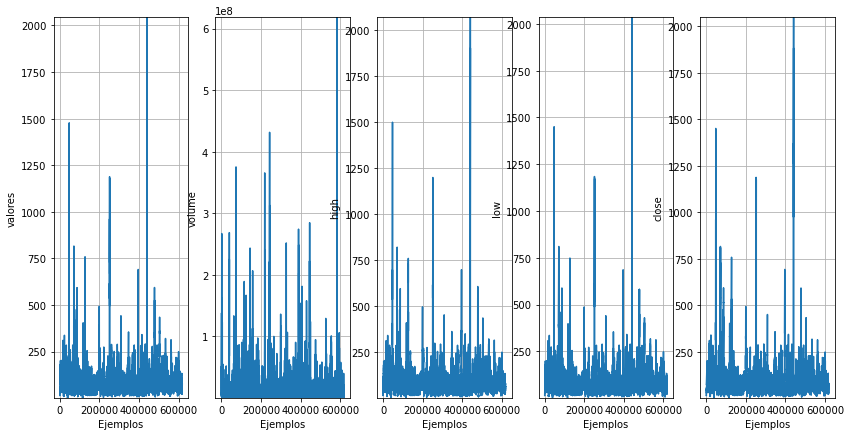

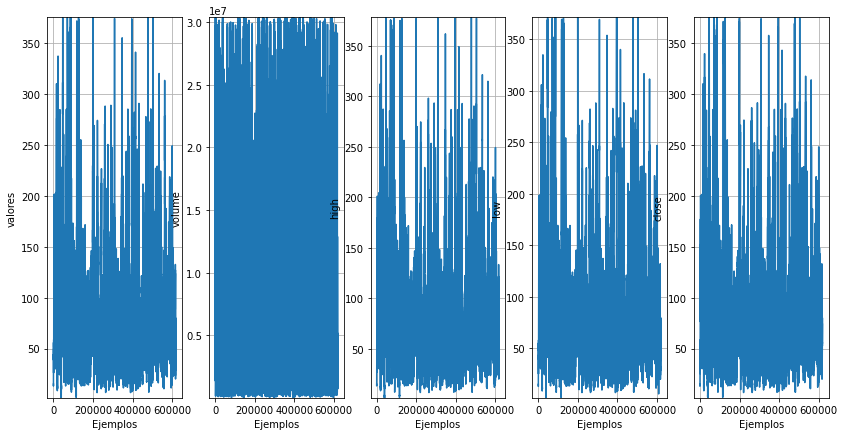

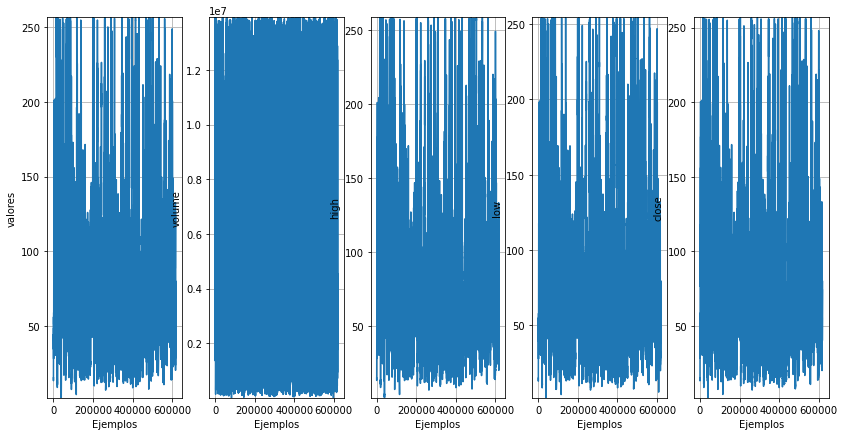

In [27]:
for datos in(dataset_valor_anterior,dataset_sin_outDesviacion,dataset_sin_outIQR):
    resumenEntrada=datos.describe()
    plt.figure(figsize=(14,7))
    plt.subplot(151)
    plt.plot(datos['open'],label='open')
    plt.xlabel('Ejemplos')
    plt.ylabel('valores')
    plt.ylim(resumenEntrada.loc[['min','max'],'open'])
    plt.grid(True)#cuadriculado

    plt.subplot(152)
    plt.plot(datos['volume'])
    plt.xlabel('Ejemplos')
    plt.ylabel('volume')
    plt.ylim(resumenEntrada.loc[['min','max'],'volume'])
    plt.grid(True)

    plt.subplot(153)
    plt.plot(datos['high'])
    plt.xlabel('Ejemplos')
    plt.ylabel('high')
    plt.ylim(resumenEntrada.loc[['min','max'],'high'])
    plt.grid(True)

    plt.subplot(154)
    plt.plot(datos['low'])
    plt.xlabel('Ejemplos')
    plt.ylabel('low')
    plt.ylim(resumenEntrada.loc[['min','max'],'low'])
    plt.grid(True)

    plt.subplot(155)
    plt.plot(datos['close'])
    plt.xlabel('Ejemplos')
    plt.ylabel('close')
    plt.ylim(resumenEntrada.loc[['min','max'],'close'])
    plt.grid(True)
    
    
    

Como se puede apreciar al usar la detección de outliers el range de los valores no varía tanto.

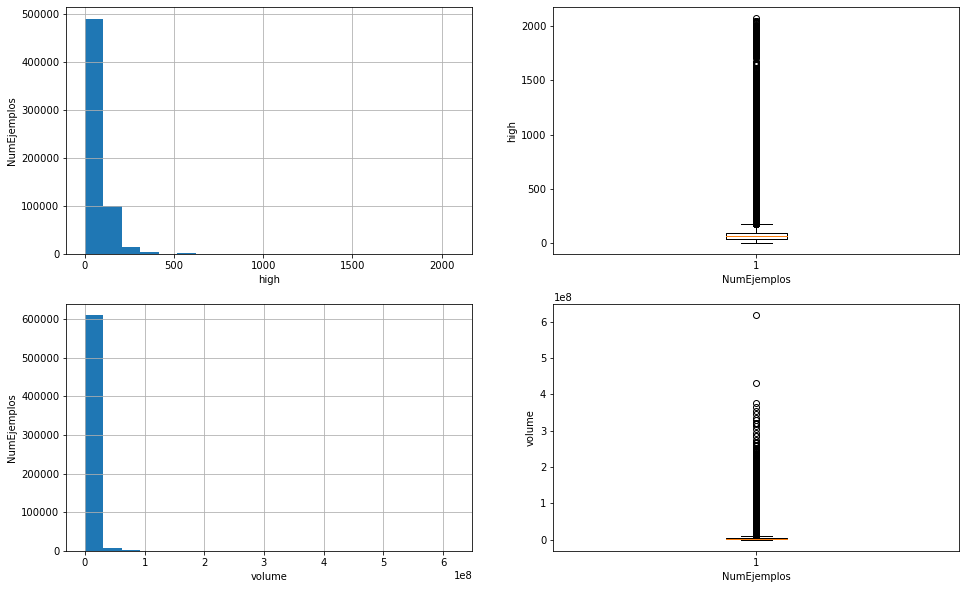

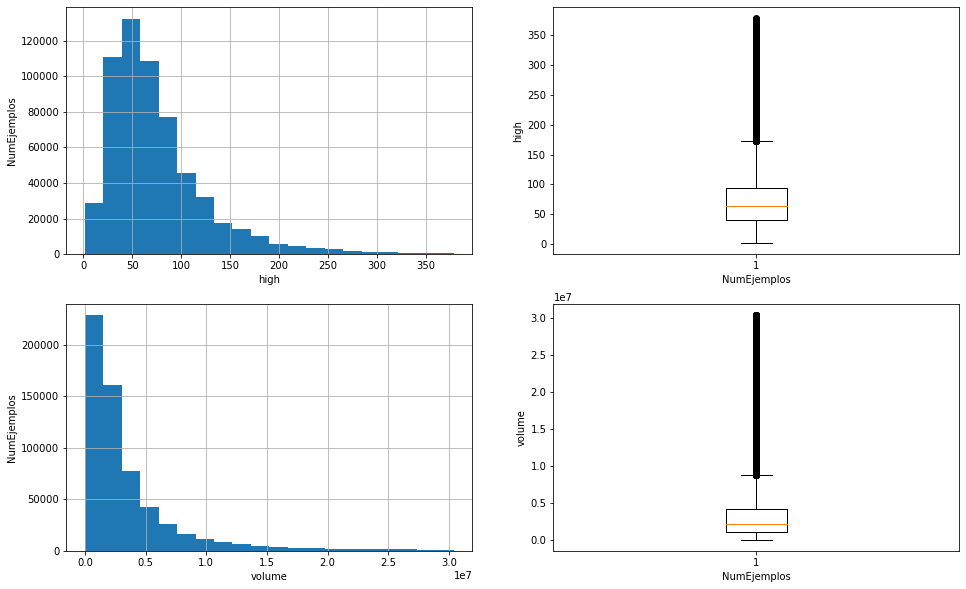

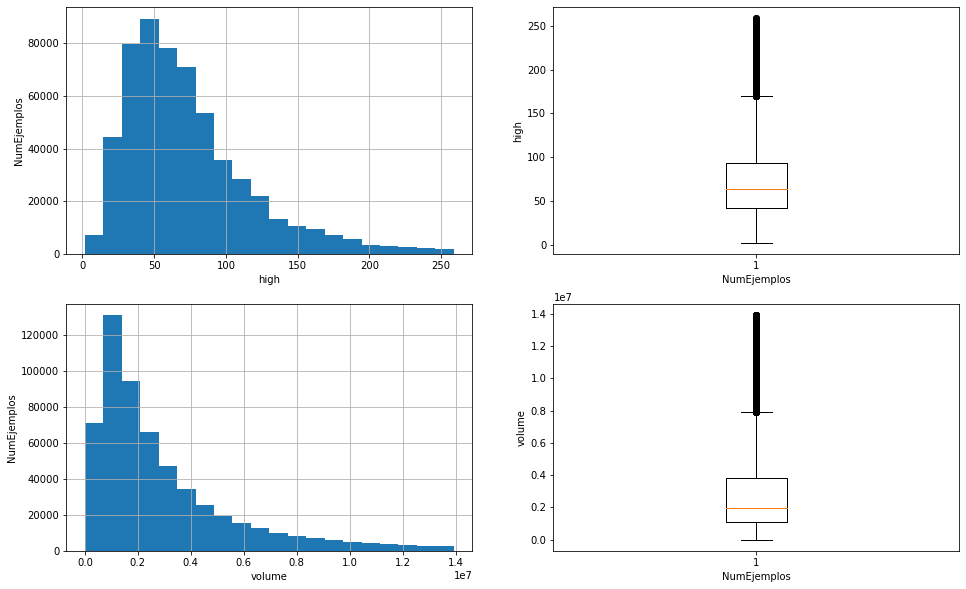

In [28]:
for datos in(dataset_valor_anterior,dataset_sin_outDesviacion,dataset_sin_outIQR):
    plt.figure(figsize=(16,10))
    plt.subplot(2,2,(1))
    datos['high'].hist(bins=20)
    plt.xlabel('high')
    plt.ylabel('NumEjemplos')
    plt.subplot(2,2,(2))
    plt.boxplot(datos['high'])
    plt.ylabel('high')
    plt.xlabel('NumEjemplos')
    plt.subplot(2,2,(3))
    datos['volume'].hist(bins=20)
    plt.xlabel('volume')
    plt.ylabel('NumEjemplos')
    plt.subplot(2,2,(4))
    plt.boxplot(datos['volume'])
    plt.ylabel('volume')
    plt.xlabel('NumEjemplos')

Como hemos mencionado los ahora los ejmplos están acotados en un rango mucho menor.

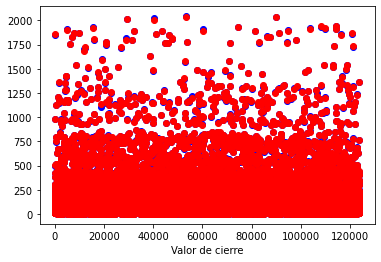

El error en entrenamiento con el dataset  es 0.4725 y en test es 0.4770


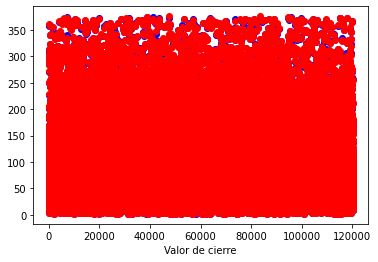

El error en entrenamiento con el dataset  es 0.2603 y en test es 0.2608


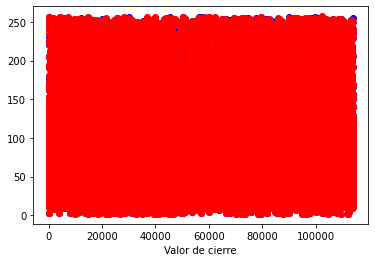

El error en entrenamiento con el dataset  es 0.2191 y en test es 0.2235


In [29]:
#utilizamos regresión polinomial para comprobar cuál de los dataframes obtiene mejores resultados mediante el error cuadrático medio
for datos in(dataset_valor_anterior,dataset_sin_outDesviacion,dataset_sin_outIQR):
    atSalida = 'close'
    atEntrada = ['open','high','low','volume']
    datos_aux=datos.copy()
    dataset_output = datos_aux[atSalida].copy()
    datos_aux.drop(atSalida, axis=1, inplace=True)
    datos_aux = datos_aux[atEntrada].copy()
    X_train, X_test, y_train, y_test = train_test_split(datos_aux, dataset_output, test_size=0.2, random_state=12)
    regresion_polinomial(datos_aux,dataset_output,2,)

Como hemos podido observar en las gráficas y confirmar mediante la regresión polinomial los mejores resultados se obtienen mediante la detección de outliers por el índice IQR.Por ello, será el dataframe que utilizaremos.

# Análisis del dataframe

In [30]:
#vemos descripcion de los datos
dataset_sin_outIQR.describe()

,open,high,low,close,volume
count,569618.000000,569618.000000,569618.000000,569618.000000,5.696180e+05
mean,73.171360,73.829278,72.509234,73.192992,2.916753e+06
std,44.309269,44.687797,43.921410,44.319706,2.669632e+06
min,1.670000,1.690000,1.610000,1.620000,1.010000e+02
25%,41.520000,41.920000,41.125000,41.540000,1.060009e+06
50%,63.140000,63.710000,62.590000,63.170000,1.985648e+06
75%,92.350000,93.180000,91.560000,92.400000,3.808268e+06
max,256.750000,258.770000,254.620000,256.890000,1.392702e+07


Se puede observar que los valores de open y close son muy similares, el de high es superior a estos y el de low es inferior lo cual tiene sentido.

Veamos algunas de las empresas con mayor tráfico de acciones por media

In [31]:
#ordenar nombres por media acciones
mas_acciones=dataset_sin_outIQR.groupby(['Name']).volume.mean().sort_values(ascending=False)
mas_acciones=mas_acciones.iloc[0:10]
print(mas_acciones)


Name
GE       1.337429e+07
AAPL     1.270635e+07
T        1.208659e+07
MU       1.196334e+07
PFE      1.191620e+07
FB       1.189712e+07
C        1.188297e+07
CMCSA    1.183778e+07
CSCO     1.176420e+07
WFC      1.176254e+07
Name: volume, dtype: float64


Como se puede observar algunas de las más destacadas son Apple, General Electric, AT&T(de telecomunicaciones)o Facebook. 

Veamos algunas de las empresas con mayor valor de acciones de sus acciones de media

In [32]:
mas_alto=dataset_sin_outIQR.groupby(['Name']).high.mean().sort_values(ascending=False)
mas_alto=mas_alto.iloc[0:10]
print(mas_alto)

Name
AMZN    255.333333
BLK     248.501766
MTD     235.068666
GWW     227.438011
BIIB    224.725326
ADS     220.320819
REGN    212.151631
ESS     204.503909
EQIX    203.729442
SHW     202.754100
Name: high, dtype: float64


Como se puede observar algunas de las más destacadas son Amazon o BlackRock que curiosamente es una empresa que se dedica a la gestión de inversiones.

Empresas con picos de valor más alto del valor de sus acciones

In [33]:
pico_mas_alto=dataset_sin_outIQR.groupby(['Name']).high.max().sort_values(ascending=False)
pico_mas_alto=pico_mas_alto.iloc[0:10]
print(pico_mas_alto)

Name
BA      258.7700
TDG     258.7000
ESS     258.6650
AGN     258.6600
ISRG    258.6364
GWW     258.6300
ALGN    258.6100
ADS     258.5700
REGN    258.5599
HUM     258.5300
Name: high, dtype: float64


# Distribución normal

Haremos que los datos sigan una distribución normal ya que así se obtienen mejores resultados en muchos modelos de evaluación, ya que muchos de ellos asumen una distribución normal en los datos.

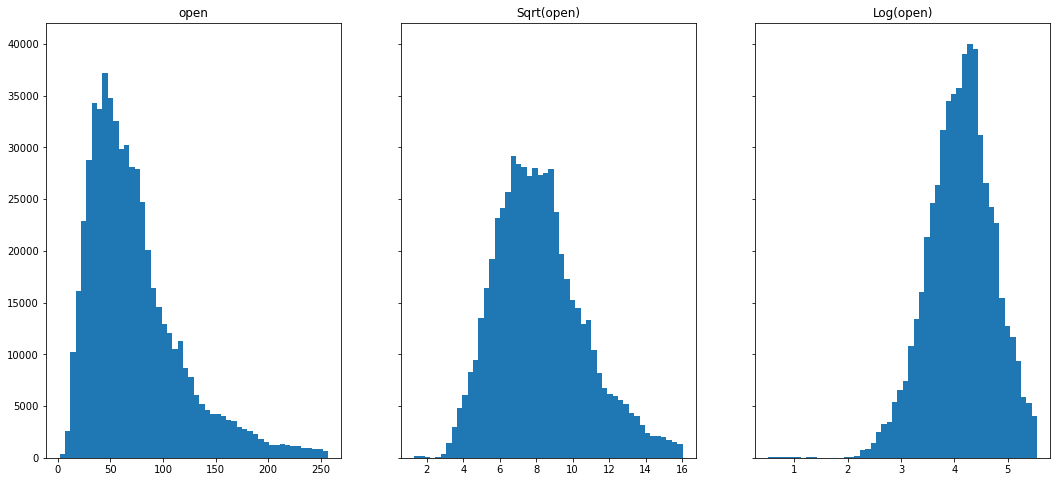

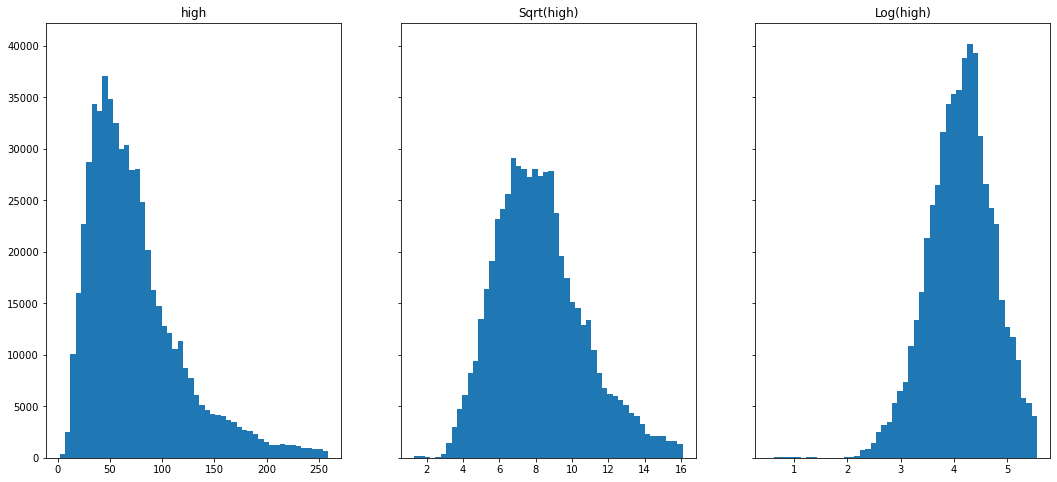

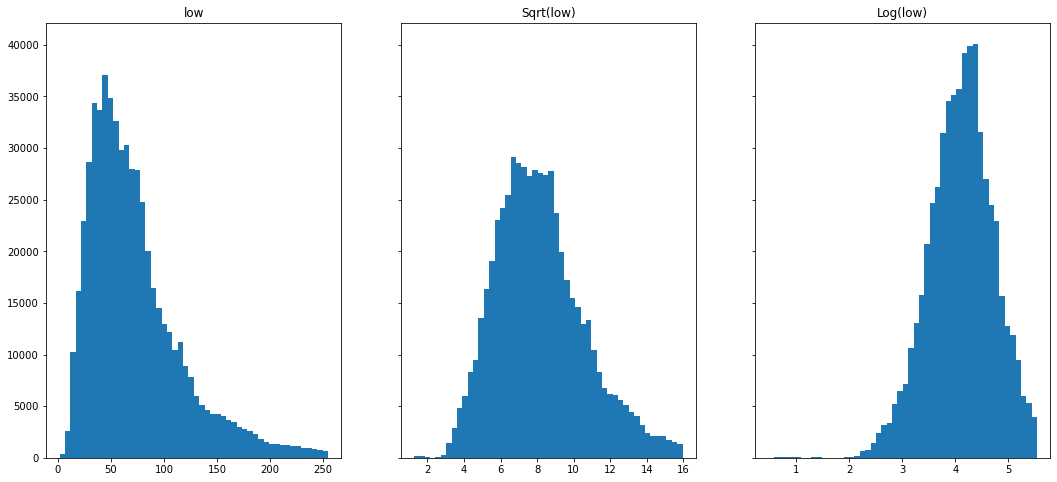

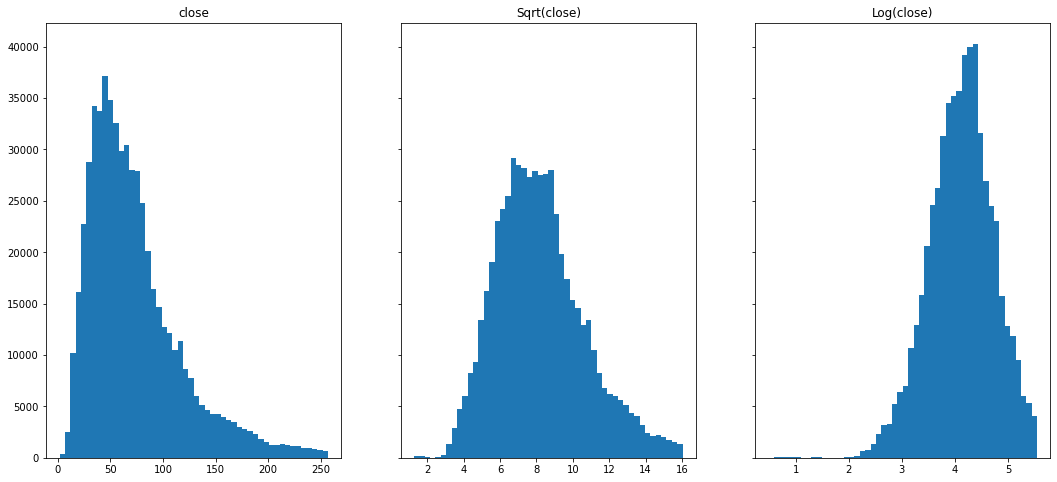

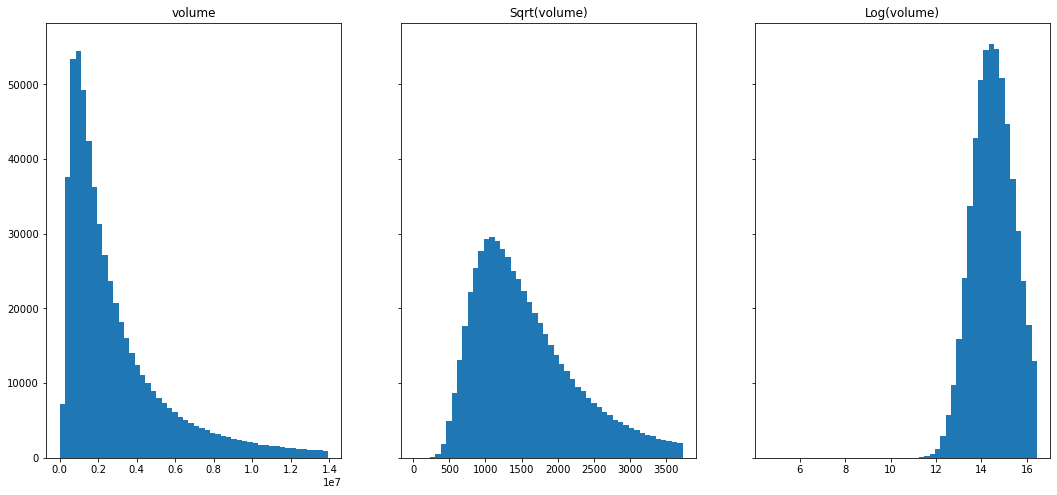

In [34]:
for valor in(nombreColumnas[1:6]):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(18,8))
    ax1.hist(dataset_sin_outIQR[valor], bins=50)
    ax1.set_title(valor)
    ax2.hist(np.sqrt(dataset_sin_outIQR[valor]), bins=50)
    ax2.set_title('Sqrt({})'.format(valor))
    ax3.hist(np.log(dataset_sin_outIQR[valor]), bins=50)
    ax3.set_title('Log({})'.format(valor));

Ahora veremos si normalizando los datos se mejoran los resultados

In [35]:
#creamos los dataframes pasando a distribución normal
dataset_log=dataset_sin_outIQR.copy()
dataset_raiz=dataset_sin_outIQR.copy()
dataset_log[nombreColumnas[1:6]]=np.log(dataset_log[nombreColumnas[1:6]])
dataset_raiz[nombreColumnas[1:6]]=np.sqrt(dataset_raiz[nombreColumnas[1:6]])

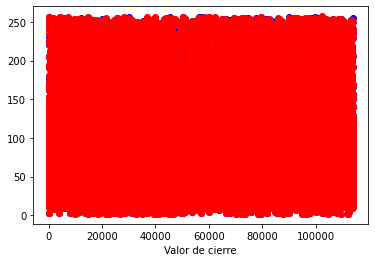

El error en entrenamiento con el dataset  es 0.2191 y en test es 0.2235


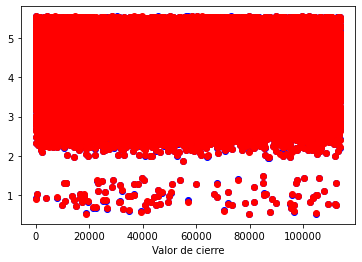

El error en entrenamiento con el dataset  es 0.0000 y en test es 0.0000


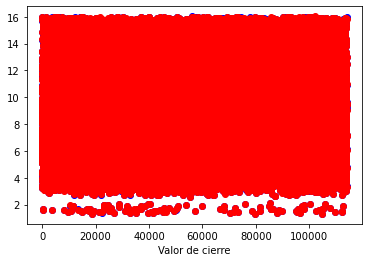

El error en entrenamiento con el dataset  es 0.0006 y en test es 0.0006


In [36]:
#utilizamos regresión polinomial para comprobar cuál de los dataframes obtiene mejores resultados mediante el error cuadrático medio
for datos in(dataset_sin_outIQR,dataset_log,dataset_raiz):
    atSalida = 'close'
    atEntrada = ['open','high','low','volume']
    datos_aux=datos.copy()
    dataset_output = datos_aux[atSalida].copy()
    datos_aux.drop(atSalida, axis=1, inplace=True)
    datos_aux = datos_aux[atEntrada].copy()
    X_train, X_test, y_train, y_test = train_test_split(datos_aux, dataset_output, test_size=0.2, random_state=12)
    regresion_polinomial(datos_aux,dataset_output,2,)

# Nuevas variables

In [37]:
def modificarFinde(dia):
    if dia in('Saturday','Sunday'):
        return 1
    else:
        return 0

In [38]:
def modificarEstacion(mes):
    if 9<=mes<=11:
        return 'Otoño'
    elif 3<=mes<=5:
        return 'Primavera'
    elif 6<=mes<=8:
        return 'Verano'
    else:
        return 'Invierno'

Vemos que al convertir los datos en una distribución normal mediante logaritmo se obtienen muy buenos resultados

In [39]:
#genero nuevas variables
dataset_nuevo=dataset_sin_outIQR.copy()
dataset_nuevo['diferencia_maxmin'] = dataset_nuevo.high - dataset_nuevo.low
dataset_nuevo['MejoraDia'] = dataset_nuevo.close - dataset_nuevo.open
dataset_nuevo.date = pd.to_datetime(dataset_nuevo.date)
dataset_nuevo['Dia'] = dataset_nuevo.date.dt.day
dataset_nuevo['Mes'] = dataset_nuevo.date.dt.month
dataset_nuevo['Año'] = dataset_nuevo.date.dt.year
dataset_nuevo['nombreDia'] = dataset_nuevo.date.dt.day_name()
dataset_nuevo['finde']=dataset_nuevo['Dia'].apply(modificarFinde)
dataset_nuevo['estacion']=dataset_nuevo['Mes'].apply(modificarEstacion)

In [40]:
mejora_1dia=dataset_nuevo.groupby(['Name']).MejoraDia.max().sort_values(ascending=False)
mejora_1dia=mejora_1dia.iloc[0:10]
print(mejora_1dia)

Name
HUM     36.03
UA      25.08
REGN    22.54
ORLY    22.00
AET     18.47
MTD     17.21
GWW     17.17
HII     16.96
RE      16.34
GD      16.28
Name: MejoraDia, dtype: float64


In [41]:
variacionDia=dataset_nuevo.groupby(['Name']).diferencia_maxmin.max().sort_values(ascending=False)
variacionDia=variacionDia.iloc[0:10]
print(variacionDia)

Name
HUM     43.3850
ULTA    43.2200
MCK     42.1799
HCA     42.0600
REGN    37.6500
ADS     33.5700
TDG     32.2500
XL      32.2200
ISRG    28.1700
INCY    27.5900
Name: diferencia_maxmin, dtype: float64


In [44]:
dataset_navidad=dataset_nuevo.copy()
dataset_navidad=dataset_navidad[(dataset_navidad['Mes']==12) & (dataset_navidad['Dia']==24) ]
navidad=dataset_navidad.groupby(['Name']).high.mean().sort_values(ascending=False)
navidad=navidad.iloc[0:10]
print(navidad)

Name
ADS     256.070000
MTD     243.790000
GWW     231.212500
AGN     212.390000
EQIX    205.435000
ESS     199.273333
AMG     198.128333
PSA     196.965000
TDG     196.383333
ORLY    193.531333
Name: high, dtype: float64
